# Weighted vs Unweighted average for azimuthal integration

The aim of this tutorial is to investigate the ability to preform unweighted averages during azimuthal integration and validate the result for intensity and uncertainties propagation. 

In [1]:
%matplotlib inline
# use `widget` instead of `inline` for better user-exeperience. `inline` allows to store plots into notebooks.
import time
import numpy
from matplotlib.pyplot import subplots
from scipy.stats import chi2 as chi2_dist
import fabio
import pyFAI
from pyFAI.gui import jupyter
from pyFAI.test.utilstest import UtilsTest
from pyFAI.utils.mathutil import rwp
t0 = time.perf_counter()

Detector Pilatus 1M	 PixelSize= 172µm, 172µm	 BottomRight (3)
Wavelength= 1.000000e-10 m
SampleDetDist= 1.583231e+00 m	PONI= 3.341702e-02, 4.122778e-02 m	rot1=0.006487  rot2=0.007558  rot3=0.000000 rad
DirectBeamDist= 1583.310 mm	Center: x=179.981, y=263.859 pix	Tilt= 0.571° tiltPlanRotation= 130.640° 𝛌= 1.000Å


<Axes: >

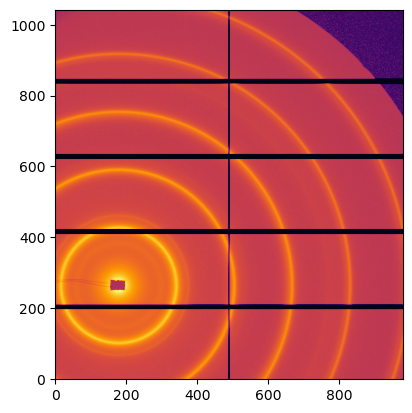

In [2]:
img = fabio.open(UtilsTest.getimage("Pilatus1M.edf")).data
ai = pyFAI.load(UtilsTest.getimage("Pilatus1M.poni"))
print(ai)
jupyter.display(img)

In [3]:
method = pyFAI.method_registry.IntegrationMethod.parse(("no", "csr", "cython"), dim=1)
weighted = method
unweighted = method.unweighted

In [4]:
#Note
weighted.weighted_average, unweighted.weighted_average, weighted == unweighted

(True, False, True)

In [5]:
res_w = ai.integrate1d(img, 1000, method=weighted, error_model="poisson", polarization_factor=0.99)
res_u = ai.integrate1d(img, 1000, method=unweighted, error_model="poisson", polarization_factor=0.99)

rwp(res_u, res_w)

0.0026844928696383593

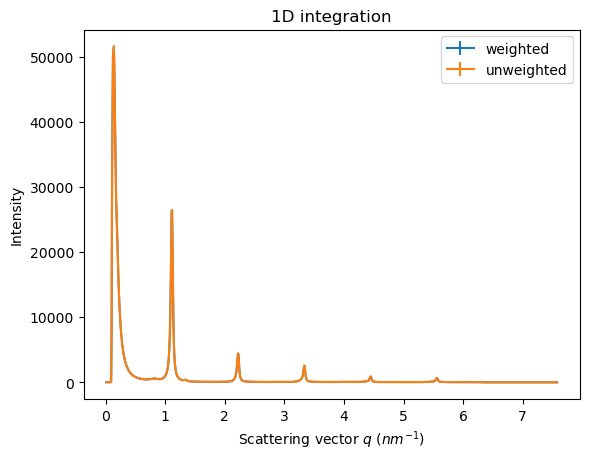

In [6]:
ax = jupyter.plot1d(res_w, label="weighted")
ax = jupyter.plot1d(res_u, label="unweighted", ax=ax)

## About statstics

Work on a dataset with 1000 frames in a WAXS like configuration

In [7]:

ai_init = {"dist":0.1, 
           "poni1":0.1, 
           "poni2":0.1, 
           "rot1":0.0,
           "rot2":0.0,
           "rot3":0.0,
           "detector": "Pilatus1M", 
           "wavelength":1e-10}
ai = pyFAI.load(ai_init)
unit = pyFAI.units.to_unit("q_A^-1")
detector = ai.detector
npt = 1000 
nimg = 1000
wl = 1e-10
I0 = 1e4
polarization = 0.99
kwargs = {"npt":npt, 
         "polarization_factor": polarization,
         "safe":False,
         "error_model": pyFAI.containers.ErrorModel.POISSON}

print(ai)          

Detector Pilatus 1M	 PixelSize= 172µm, 172µm	 BottomRight (3)
Wavelength= 1.000000e-10 m
SampleDetDist= 1.000000e-01 m	PONI= 1.000000e-01, 1.000000e-01 m	rot1=0.000000  rot2=0.000000  rot3=0.000000 rad
DirectBeamDist= 100.000 mm	Center: x=581.395, y=581.395 pix	Tilt= 0.000° tiltPlanRotation= 0.000° 𝛌= 1.000Å


In [8]:
# Generation of a "SAXS-like" curve with the shape of a lorentzian curve
flat = numpy.random.random(detector.shape) + 0.5

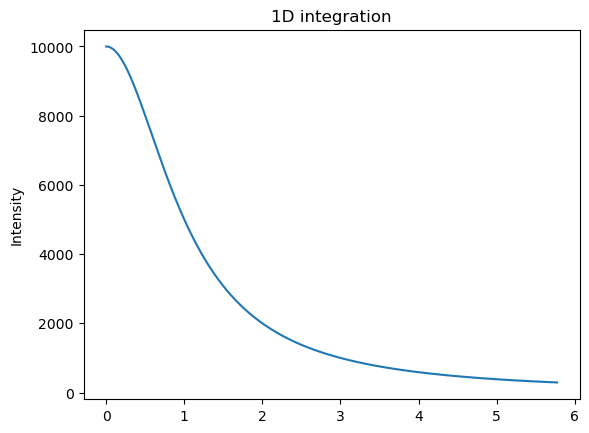

In [9]:
qmax = ai.integrate1d(flat, method=method, **kwargs).radial.max()
q = numpy.linspace(0, ai.array_from_unit(unit="q_A^-1").max(), npt)
I = I0/(1+q**2)
jupyter.plot1d((q,I))
pass

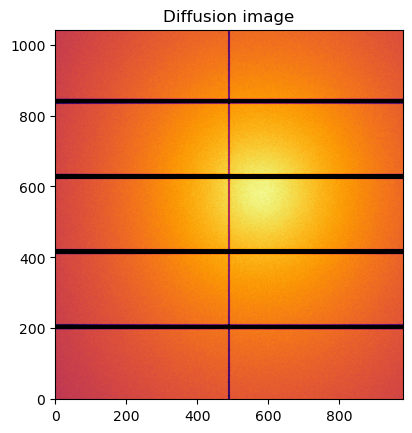

In [10]:
#Reconstruction of diffusion image:

img_theo = ai.calcfrom1d(q, I, dim1_unit=unit, 
                         correctSolidAngle=True,
                         flat=flat,
                         polarization_factor=polarization,
                         mask=ai.detector.mask)
kwargs["flat"] = flat

jupyter.display(img_theo, label="Diffusion image")
pass

<Axes: title={'center': '1D integration'}, xlabel='Scattering vector $q$ ($nm^{-1}$)', ylabel='Intensity'>

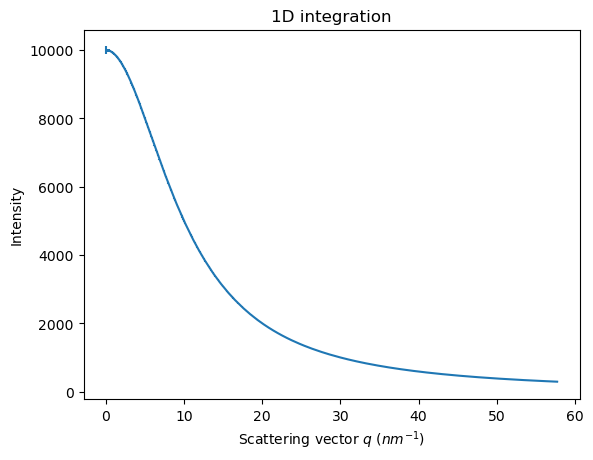

In [11]:
res_theo = ai.integrate1d(img_theo, method=method, **kwargs)
jupyter.plot1d(res_theo)

In [12]:
%%time
if "dataset" not in dir():
    dataset = numpy.random.poisson(img_theo, (nimg,) + img_theo.shape)
# else avoid wasting time
print(dataset.nbytes/(1<<20), "MBytes", dataset.shape)

7806.266784667969 MBytes (1000, 1043, 981)
CPU times: user 1min, sys: 8.66 s, total: 1min 9s
Wall time: 1min 9s


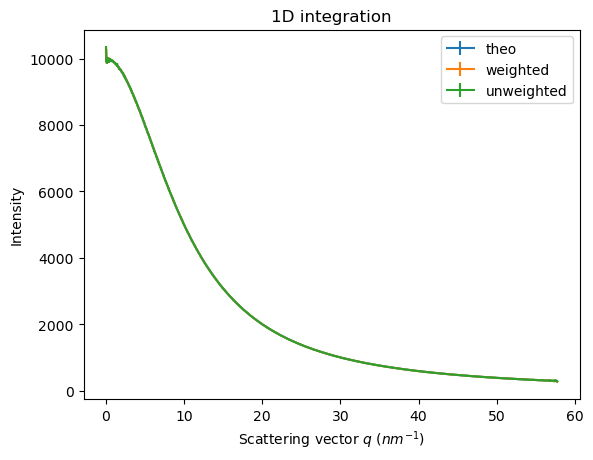

In [13]:
res_weighted = ai.integrate1d(dataset[0], method=weighted, **kwargs)
res_unweighted = ai.integrate1d(dataset[0], method=unweighted, **kwargs)
                              
ax = jupyter.plot1d(res_theo, label="theo")
ax = jupyter.plot1d(res_weighted, label="weighted", ax=ax)
ax = jupyter.plot1d(res_unweighted, label="unweighted", ax=ax)

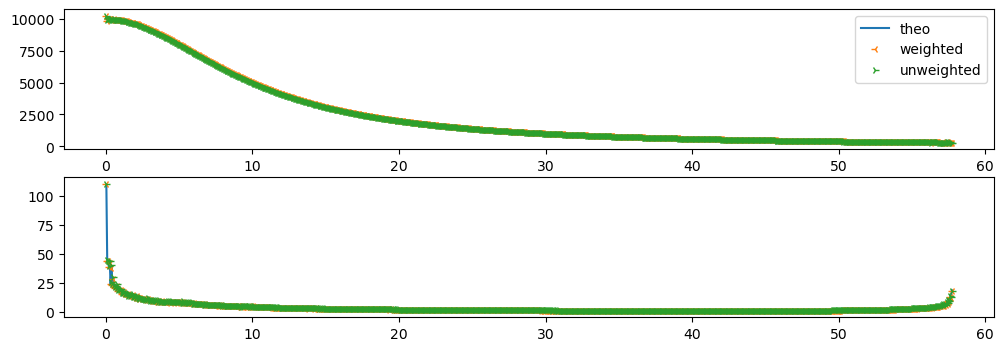

In [14]:
fix,ax = subplots(2, figsize=(12,4))
ax[0].plot(res_theo.radial, res_theo.intensity, label="theo")
ax[1].plot(res_theo.radial, res_theo.sigma, label="theo")
ax[0].plot(res_weighted.radial, res_weighted.intensity, "3", label="weighted")
ax[1].plot(res_weighted.radial, res_weighted.sigma, "3",label="weighted")
ax[0].plot(res_unweighted.radial, res_unweighted.intensity, "4", label="unweighted")
ax[1].plot(res_unweighted.radial, res_unweighted.sigma, "4", label="unweighted")
ax[0].legend()

In [15]:
print("Number of paires of images: ", nimg*(nimg-1)//2)

Number of paires of images:  499500


In [16]:
def chi2_curves(res1, res2):
    """Calculate the Chi² value for a pair of integrated data"""
    I = res1.intensity
    J = res2.intensity
    l = len(I)
    assert len(J) == l
    sigma_I = res1.sigma
    sigma_J = res2.sigma
    return ((I-J)**2/(sigma_I**2+sigma_J**2)).sum()/(l-1)

In [17]:
def plot_distribution(ai, kwargs, nbins=100, method=method, ax=None):
    ai.reset()
    results = []
    c2 = []
    integrate = ai.integrate1d
    for i in range(nimg):
        data = dataset[i, :, :]
        r = integrate(data, method=method, **kwargs)
        results.append(r)    
        for j in results[:i]:
            c2.append(chi2_curves(r, j))
    c2 = numpy.array(c2)
    if ax is None:
        fig, ax = subplots()
    h,b,_ = ax.hist(c2, nbins, label="Measured histogram")
    y_sim = chi2_dist.pdf(b*(npt-1), npt)
    y_sim *= h.sum()/y_sim.sum()
    ax.plot(b, y_sim, label=r"$\chi^{2}$ distribution")
    ax.set_title(f"Integrated curves with {integrate.__name__}")
    ax.set_xlabel("$\chi^{2}$ values (histogrammed)")
    ax.set_ylabel("Number of occurences")
    ax.legend()
    return ax

Text(0.5, 1.0, 'Weighted')

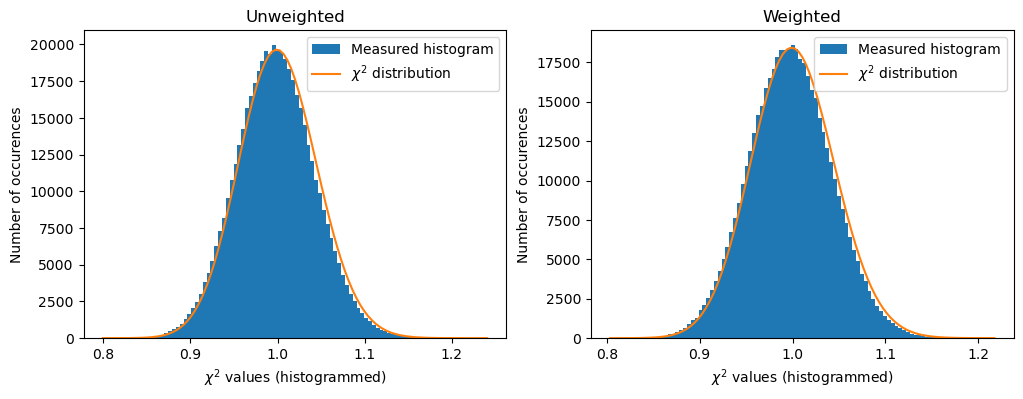

In [18]:
fig,ax = subplots(1,2, figsize=(12,4))
a=plot_distribution(ai, kwargs, method=unweighted, ax=ax[0])
a.set_title("Unweighted")
a=plot_distribution(ai, kwargs, method=weighted, ax=ax[1])
a.set_title("Weighted")

In [19]:
print(rwp(ai.integrate1d(dataset[100], method=weighted, **kwargs),
          ai.integrate1d(dataset[100], method=unweighted, **kwargs)))

0.042466367526137465


In [20]:
print(f"Total run-time: {time.perf_counter()-t0:.3f}s")

Total run-time: 125.184s


## Conclusion

The two algorithms provide similar results but not strictly the same. 
The difference is largely beyond the numerical noise since the Rwp between two results is in the range of a few percent.
Their performances for the speed is also equivalent.
Their results are different but on a statistical point of view, it is difficult to distinguish them.

To me (J. Kieffer, author of pyFAI), the question of the best algorithm remains open.